##Libraries&Load Data


In [25]:
pip install -U pymoo

In [26]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.problems.functional import FunctionalProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

import pandas as pd
import numpy as np
import random
import tensorflow as tf
import joblib
import pickle
from scipy.optimize import minimize, LinearConstraint

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
path = '/content/drive/MyDrive/Tesi/data/Dati/'
data_load_path = path + 'data/load/data_load.xlsx'
data_prod_path = path + 'data/production/data_production.xlsx'
data_load = pd.read_excel(data_load_path, decimal=',')
data_prod = pd.read_excel(data_prod_path, decimal=',')
data_load = data_load.set_index("datetime")
data_prod = data_prod.set_index("datetime")

def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
      row = [a for a in df_as_np[i : i + window_size]]
      X.append(row)
      label = df_as_np[i + window_size]
      y.append(label)
  return np.array(X), np.array(y)

win_size = 3
X_load, y_load = df_to_X_y(data_load, win_size)
X_prod, y_prod = df_to_X_y(data_prod, win_size)

y_load = y_load.flatten()
y_prod = y_prod.flatten()

In [29]:
# Load the models

model_load_path = path + 'models/load/gru_model.keras'
model_load_gru = tf.keras.models.load_model(model_load_path)
model_load_path = path + 'models/production/lstm_model.keras'
model_prod_lstm = tf.keras.models.load_model(model_load_path)

# Make predictions using the loaded model

load = data_load.iloc[3:]
load['pred'] = model_load_gru.predict(X_load).flatten()
load['pred'] = load['pred'].abs()

# Make predictions using the loaded model

prod = data_prod.iloc[3:]
prod['pred'] = model_prod_lstm.predict(X_load).flatten()
prod['pred'] = prod['pred'].abs()

def operation(val):
    return val / 3 * 5

prod = prod.applymap(operation)

274/274 [==============================] - 2s 7ms/step


<ipython-input-29-b0b8074150d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['pred'] = model_load_gru.predict(X_load).flatten()
<ipython-input-29-b0b8074150d2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['pred'] = load['pred'].abs()


274/274 [==============================] - 3s 6ms/step


<ipython-input-29-b0b8074150d2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['pred'] = model_prod_lstm.predict(X_load).flatten()
<ipython-input-29-b0b8074150d2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['pred'] = prod['pred'].abs()


##Data Generation

In [30]:
n_prosumers = 3
n_consumers = 2
omega_t = [str(ts) for ts in load.index]
#omega_t = 24
omega_alpha = n_prosumers + n_consumers
D = 5
C = 5

In [31]:
# Generation of data

tot_load_m = []
tot_prod_m = []
x = np.array([1, 2, 3, 4, 5])
result = (x / 3) * 5

for t in range(len(omega_t)):
    p = prod.loc[omega_t[t],'pred']
    l = load.loc[omega_t[t], 'pred']
    tot_load = []
    tot_prod = []
    for i in range(n_prosumers):
        if (p > 0):
          deviation = random.uniform(-0.02, 0.02)
          pi = p + deviation

          deviation = random.uniform(-0.02, 0.02)
          ci = l + deviation

          if pi > ci:
              tot_load.append(0)
              tot_prod.append(pi-ci)
          elif pi == ci:
              tot_load.append(0)
              tot_prod.append(0)
          else:
              tot_load.append(ci-pi)
              tot_prod.append(0)
        else:
          tot_prod.append(0)
          deviation = random.uniform(-0.02, 0.02)
          ci = l + deviation
          tot_load.append(ci)

    for i in range(n_consumers):
        deviation = random.uniform(-0.02, 0.02)
        ci = l + deviation
        tot_load.append(ci)
        tot_prod.append(0)

    tot_prod_m.append(tot_prod)
    tot_load_m.append(tot_load)


# Multiobjective optimization

In [32]:
#      h0      h1    h2      h3     h4
#     0 1     2 3    4 5    6 7     8 9
# t0  I X     I X    I X    I X     I X
#     10 11  12 13  14 15    18 19  20 21
# t1  I  X   I  X    I X    I X    I X
#     30 31  32 33  34 35   36 37  38 39
# t2  I X    I X     I X    I X    I X
# ...
# t24
#     C_LEM_1 ... C_LEM_24
#   504 variabili
#   0  1  2  3  4  5  6  7  8  9   10   11  12  13                                 22  23  24   25 26   27    119   120 121 ... 239   240      359   360 361    480     481       504
#   I1 I2 I3 I4 I5 I6 I7 I8 I9 I10 I11 I12 I13 I14 I15 I16 I17 I18 I19 I20 I21 I22 I23 I24 I25 I26 I27 I28... I120  X1  X2  ... X120   G1 ... G120    E1 E2 ...E120    C_LEM1 ...C_LEM24

In [33]:
omega_t = 24
omega_alpha = 5
D = 0
C = 0
c_spot = [185.59, 180.28, 177.73, 177.12, 178.50, 183.65, 189.67, 247, 249,
          190.05, 180.23, 180.23, 164.10, 163.90, 163.90, 171.73, 171.73,
          182.61, 191.84, 253.75, 275, 249, 191.84, 186.30]
C_spot = [mwh / 1000 for mwh in c_spot]
C_sell = 0.05
n_var = omega_t*omega_alpha*3
df = pd.DataFrame(columns=['dem', 'res_pv', 'D', 'C', 'C_sell', 'C_spot'])
for t in range(24):
    c = C_spot[t]
    for h in range(omega_alpha):
        row_values = [tot_load_m[t][h], tot_prod_m[t][h], D, C, C_sell, c]
        df.loc[len(df)] = row_values

In [34]:
d = 0
def objective_function_1(x):
    f1 = 0
    for t in range(omega_t):
      for h in range(omega_alpha):
        i = t*5+h
        f1 += C_spot[t] * x[i+240] + (1.05) * x[-t] * x[i] - C_sell * x[i+360] - (0.95) * x[-t] * x[i+120]
    return f1

def objective_function_2(x):
    f2 = 0
    for t in range(omega_t):
      for h in range(omega_alpha):
        f2 += -x[t*5+h]
    return f2

def constraint_1(x):
  d = 0
  s = 0
  for t in range(omega_t):
    for h in range(omega_alpha):
      i = t*5+h
      s += x[i+240] + x[i] + df['D'].loc[t] + df['res_pv'].loc[t]
      d += df['dem'].loc[t] + x[i+120] + df['C'].loc[t] + x[i+360]
      #s += x[i+240] + x[i] + df['res_pv'].loc[t]
      #d += df['dem'].loc[t] + x[i+120] + x[i+360]
  return s - d

def constraint_2(x):
  s_X = 0
  s_I = 0
  for t in range(omega_t):
    for h in range(omega_alpha):
      i = t*5+h
      s_I +=x[i]
      s_X += x[i+120]
  return s_X - s_I

def constraint_3(x):
  d = 0
  dem = 0
  for t in range(omega_t):
    for h in range(omega_alpha):
      i = t*5+h
      d   += x[i] + x[i+120]
      dem += df['dem'].loc[i]
  return dem - d

def constraint_4(x):
  r = 0
  res = 0
  for t in range(omega_t):
    for h in range(omega_alpha):
      i    = t*5+h
      r   += x[i+120] + x[i+360]
      res += df['res_pv'].loc[i]
      # -(res - (X+E) - 0.1) < 0
  return - (abs(res - r) - 0.1)

In [36]:
merged_df

,dem,res_pv,D,C,C_sell,C_spot,C_LEM,I,G,X,E
0,0.0000,0.0212,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0161,0.0096
1,0.0000,0.0254,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0196,0.0149
2,0.0000,0.0453,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0364,0.0281
3,0.1361,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.0282,0.0798,0.0000,0.0000
4,0.1175,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.1110,0.0949,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
115,0.0000,0.0544,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0060,0.0062
116,0.0000,0.0309,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0173,0.0287
117,0.0000,0.0628,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0055,0.0327
118,0.1233,0.0000,0.0,0.0,0.05,0.1863,0.0830,0.0123,0.0016,0.0000,0.0000


In [35]:
objs = [objective_function_1, objective_function_2]
c_ieq = [constraint_1]
c_eq = [constraint_2, constraint_3, constraint_4]
n_var = 504
xu = np.full(n_var, 0.05)
xu[:120] = df['dem']
xu[120:240] = df['res_pv']
xu[240:360] = df['dem']
xu[360:480] = df['res_pv']
xu[480:] = C_spot
problem = FunctionalProblem(n_var,
                            objs,
                            constr_ieq=c_ieq,
                            constr_eq=c_eq,
                            xl=np.zeros(n_var),
                            xu=xu
                           )
F, G, H = problem.evaluate(np.random.rand(3, n_var))
#F, H = problem.evaluate(np.random.rand(3, n_var))

class MyRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[:, 0] = 1/3 * X[:, 1]
        return X

def multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination):
    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=prob, eta=eta_1),
        mutation=PM(eta=eta_2),
        eliminate_duplicates=True,
        repair=MyRepair()
    )
    termination = get_termination("n_gen", termination)
    res = minimize(problem,
                  algorithm,
                  termination,
                  seed=1,
                  return_least_infeasible=True,
                  save_history=False,
                  verbose=False)
    X = res.X
    F = res.F
    fl = F.min(axis=0)
    fu = F.max(axis=0)
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    fl_2 = nF.min(axis=0)
    fu_2 = nF.max(axis=0)
    weights = np.array([0.5, 0.5])
    decomp = ASF()
    i = decomp.do(nF, 1/weights).argmin()
    i_2 = PseudoWeights(weights).do(nF)
    return X[i]

# D, C = 5

In [24]:
results_multiobj = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
pop_size = 100
n_offsprings = 50
prob = 0.9
eta_1 = 15
eta_2 = 15
termination = 50
omega_t = 24
omega_alpha = 5
result = multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination)
variables = pd.DataFrame(columns=['C_LEM', 'I', 'G', 'X','E'])
for t in range(omega_t):
    for h in range(omega_alpha):
        i = t*5+h
        I = result[i]
        X = result[i+120]
        G = result[i+240]
        E = result[i+360]
        C_LEM = result[-(t+1)]
        row_values = [C_LEM, I, G, X, E]
        variables.loc[len(variables)] = row_values
merged_df_2 = pd.merge(df, variables, left_index=True, right_index=True, how='inner')
merged_df_2 = merged_df_2.round(4)
merged_df_2

<ipython-input-23-941bbc9a782c>:50: RuntimeWarning: invalid value encountered in divide
  nF = (F - approx_ideal) / (approx_nadir - approx_ideal)


,dem,res_pv,D,C,C_sell,C_spot,C_LEM,I,G,X,E
0,0.0000,0.0212,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0161,0.0096
1,0.0000,0.0254,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0196,0.0149
2,0.0000,0.0453,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0364,0.0281
3,0.1361,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.0282,0.0798,0.0000,0.0000
4,0.1175,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.1110,0.0949,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
115,0.0000,0.0544,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0060,0.0062
116,0.0000,0.0309,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0173,0.0287
117,0.0000,0.0628,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0055,0.0327
118,0.1233,0.0000,0.0,0.0,0.05,0.1863,0.0830,0.0123,0.0016,0.0000,0.0000


<Axes: >

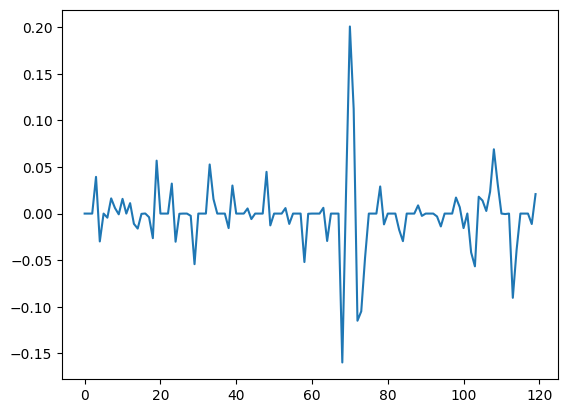

In [ ]:
s = merged_df_2['dem'] - merged_df_2['G'] - merged_df_2['I']
s.plot()

<Axes: >

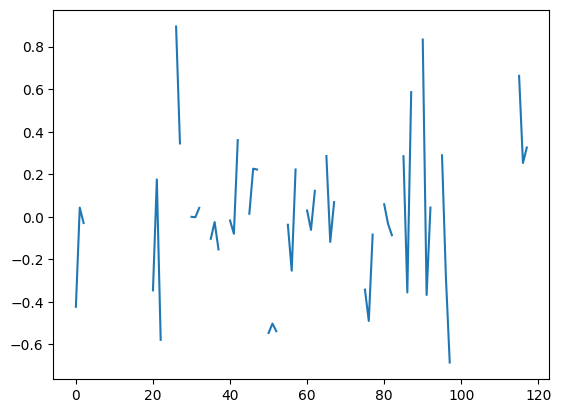

In [ ]:
s = (merged_df_2['res_pv'] - merged_df_2['X'] - merged_df_2['E']) / merged_df_2['res_pv']
s.plot()

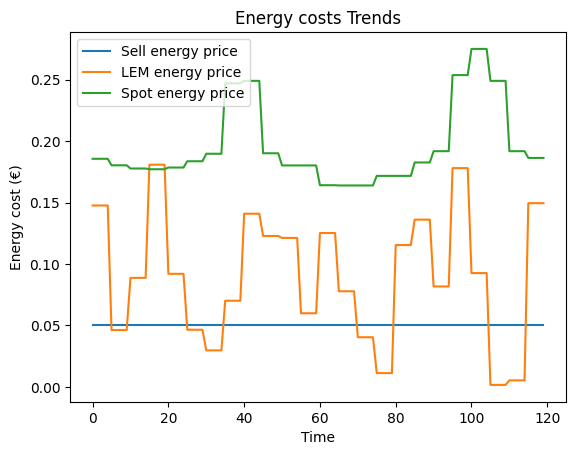

In [ ]:
import matplotlib.pyplot as plt

plt.plot(merged_df['C_sell'], label='Sell energy price')
plt.plot(merged_df['C_LEM'], label='LEM energy price')
plt.plot(merged_df['C_spot'], label='Spot energy price')
plt.xlabel('Time')
plt.ylabel('Energy cost (€)')
plt.title('Energy costs Trends')
plt.legend()
plt.show()

In [ ]:
df.to_excel("optimization_results.xlsx", index=False)

# D, C = 0

In [19]:
results_multiobj = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
pop_size = 100
n_offsprings = 50
prob = 0.9
eta_1 = 15
eta_2 = 15
termination = 50
omega_t = 24
omega_alpha = 5
result = multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination)
variables = pd.DataFrame(columns=['C_LEM', 'I', 'G', 'X','E'])
for t in range(omega_t):
    for h in range(omega_alpha):
        i = t*5+h
        I = result[i]
        X = result[i+120]
        G = result[i+240]
        E = result[i+360]
        C_LEM = result[-(t+1)]
        row_values = [C_LEM, I, G, X, E]
        variables.loc[len(variables)] = row_values
merged_df = pd.merge(df, variables, left_index=True, right_index=True, how='inner')
merged_df = merged_df.round(4)
merged_df

<ipython-input-18-9492da8bdf41>:50: RuntimeWarning: invalid value encountered in divide
  nF = (F - approx_ideal) / (approx_nadir - approx_ideal)


,dem,res_pv,D,C,C_sell,C_spot,C_LEM,I,G,X,E
0,0.0000,0.0212,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0161,0.0096
1,0.0000,0.0254,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0196,0.0149
2,0.0000,0.0453,0.0,0.0,0.05,0.1856,0.0629,0.0000,0.0000,0.0364,0.0281
3,0.1361,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.0282,0.0798,0.0000,0.0000
4,0.1175,0.0000,0.0,0.0,0.05,0.1856,0.0629,0.1110,0.0949,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
115,0.0000,0.0544,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0060,0.0062
116,0.0000,0.0309,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0173,0.0287
117,0.0000,0.0628,0.0,0.0,0.05,0.1863,0.0830,0.0000,0.0000,0.0055,0.0327
118,0.1233,0.0000,0.0,0.0,0.05,0.1863,0.0830,0.0123,0.0016,0.0000,0.0000


<Axes: >

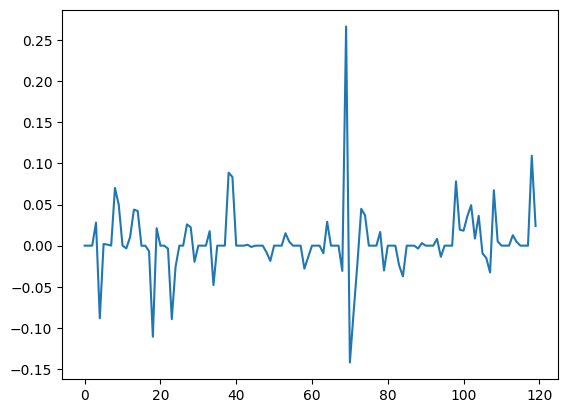

In [20]:
s = merged_df['dem'] - merged_df['G'] - merged_df['I']
s.plot()

<Axes: >

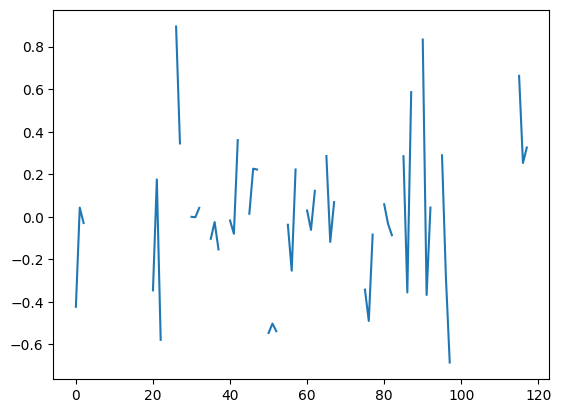

In [ ]:
s = (merged_df['res_pv'] - merged_df['X'] - merged_df['E']) / merged_df['res_pv']
s.plot()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(merged_df['C_sell'], label='Sell energy price')
plt.plot(merged_df['C_LEM'], label='LEM energy price')
plt.plot(merged_df['C_spot'], label='Spot energy price')
plt.xlabel('Time')
plt.ylabel('Energy cost (€)')
plt.title('Energy costs Trends')
plt.legend()
plt.show()

# Tests

In [ ]:
i = 102
print((merged_df['dem'].loc[i] + merged_df['X'].loc[i]) + merged_df['C'].loc[i] + merged_df['E'].loc[i])
print((merged_df['G'].loc[i] + merged_df['I'].loc[i]) + merged_df['D'].loc[i] + merged_df['res_pv'].loc[i])

5.077
5.0755


In [ ]:
print(sum(merged_df['I']))
print(sum(merged_df['X']))

3.6455999999999995
3.7539000000000007


In [ ]:
i = 100
print(merged_df['dem'].loc[i])
print(merged_df['I'].loc[i] + merged_df['G'].loc[i])

0.0746
0.0707


In [ ]:
i = 100
print(merged_df['res_pv'].loc[i])
print(merged_df['X'].loc[i] + merged_df['E'].loc[i])

0.0
0.0


In [15]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  1.239636E+01 |  0.000000E+00 |             f
     3 |       60 |      2 |  0.000000E+00 |  5.4620972973 |  1.0000000000 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  2.3938570636 |  0.000000E+00 |             f
     5 |       80 |      2 |  0.000000E+00 |  1.1200787779 |  0.000000E+00 |             f
     6 |       90 |      3 |  0.000000E+00 |  0.1858089725 |  0.1785481247 |             f
     7 |      100 |      4 |  0.000000E+00 |  0.0096392745 |  0.0639961700 |         ideal
     8 |      110 |      5 |  0.000000E+00 |  0.0016302512 |  0.0912676400 |         ideal
     9 |      120 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1217555949 |         ideal
    10 |      130 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0038809178 |             f